# LunarLander v2
## The description of the task
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Source: https://gym.openai.com/envs/LunarLander-v2/

## Approach to resolve the task

To resolve the task has been used a deep Q-network (DQN), implemented by Keras framework. The best model and optimal hyper parameters found by a grid search, running `lunarlander.py` script.

![Ideal landing. 2010th episode](lunarlander.gif)

The search grid can be set by editing `lunarlander.py`, for the instance:
```python
    # Grid parameters
    num_learns = [1, 2]
    epochs = [1,4]
    lookbacks = [10000, 20000, 30000]
    batch_sizes = [32]
```
where:
* `num_learn` - how many independent batches and fitting procedure will be used to fit the model after the each step;
* `epochs` - the number of epochs for each running the fit procedure;
* `lookbacks` - the deep of a data history used to get the batches;
* `batch_sizes` - the size of batch to the model;

### Running the script
Activating a conda virtual environment and running the script:
```python
source activate /opt/envs/ML
setsid python lunarlander.py > ll.log 2>&1
```

Checking the perfomance of model(s):

In [3]:
!grep TEST ll.log

ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 210: [10  0  0] -78 -48 -58 [0 7 3 0] -2 2 -1
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 410: [0 8 2] 89 215 178 [0 2 1 7] -0 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 610: [2 6 2] -14 225 143 [1 1 0 8] -100 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 810: [3 3 4] -63 267 113 [2 1 2 5] -100 100 50
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 1010: [ 0  0 10] 239 285 266 [ 0  0  0 10] 100 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 1210: [0 2 8] 102 299 250 [0 1 1 8] -0 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 1410: [ 0  0 10] 237 308 281 [ 0  0  0 10] 100 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 1610: [ 0  0 10] 217 296 250 [ 0  0  0 10] 100 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 1810: [ 0  0 10] 230 305 283 [ 0  0  0 10] 100 100 100
ll-128relu-64relu-4linear-nl1-epochs1-lb300

where, for instance `ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32 TEST 410: [0 8 2] 89 215 178 [0 2 1 7] -0 100 100` row:
* `128relu-64relu-4linear` - dense neural network with 128 input, 64 hidden and 4 output neurons with `relu` activation for first two layers and `linear` activation for output layer respectively;
* `nl1` - paramter `num_learn`=1;
* `epochs1` - one epoch for each fitting;
* `lb30000` - using 30000 last steps in the data history to get the batch;
* `bs32` - batch size is set to 32;
* `410` - the test running with 10 episodes and the epsilon parameter equal 0 after 400 episodes of training;
* `[0 8 2]` - 0 episodes are finished with summarized reward <= 0, 8 episodes >0 and <= 200 and 2 episodes with summarized reward > 200;
* `89` - the minimal summarized reward;
* `215` - the maximal summarized reward;
* `178` - the median summarized reward;
* `[0 2 1 7]` - 0 episodes were finished with the last reward equal -100, -100 < 2 episodes <=0, 0 < 1 episode < 100, 7 episodes with last reward equal 100;
* `-0` - a liitle less than 0, the minimal last reward;
* `100` - the maximal last reward;
* `100` - the median last reward;

Copying the perspective models by episodes:

In [4]:
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-410.h5 models/.
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1010.h5 models/.
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410.h5 models/.
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1610.h5 models/.
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1810.h5 models/.
!cp data/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010.h5 models/.

[The progress in learning by episodes](https://youtu.be/GSNgYPWdHQA).

[![Skills by episodes](https://img.youtube.com/vi/GSNgYPWdHQA/0.jpg)](https://youtu.be/GSNgYPWdHQA/watch?v=GSNgYPWdHQA)

## Detailed analysis of the performance of the perspective models.

In [8]:
import gym
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ntpath
import re

from keras.models import load_model

In [2]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [12]:
MODELDIR='models'
model_file_mask = f'{MODELDIR}/*h5'

df = pd.DataFrame(
    columns={
        'model': str,
        'episode': np.uint,
        'step': np.uint,
        'reward': np.float,
        'done': np.bool
    }
)

env = gym.make('LunarLander-v2')

# N is number of running for the each model
N=100

RE_MODEL_PATTERN = r'll-(\S+)-nl(\d+)-epochs(\d+)-lb(\d+)-bs(\d+)-model-(\d+)'

In [13]:
def parce_model(line):
    g = re.match(RE_MODEL_PATTERN, str(line))
    if g:
        grps = g.groups()
        return grps

Run the each model N times:

In [14]:
for file in glob.glob(model_file_mask):
    name = ntpath.basename(file).split('.')[0]
    model_par = parce_model(name)
    with open(file, encoding='utf-8') as f:
        model = load_model(file)
        for i in range(N):
            s = env.reset()
            s = s.reshape(1, 8)
            done = False
            step = 1
            while not done:
                s_pred = model.predict(s)
                a = np.argmax(s_pred)
                new_s, r, done, _ = env.step(a)
                s = new_s.reshape(1, 8)
                df = df.append(
                    {
                        'model': name,
                        'nn': model_par[0],
                        'nl': model_par[1],
                        'epochs': model_par[2],
                        'lb': model_par[3],
                        'bs': model_par[4],
                        'train_ep': model_par[5],
                        'episode': i,
                        'step': step,
                        'reward': r,
                        'done': done
                    },
                    ignore_index=True
                )
                step+=1

Getting the last rewards for the each test and groupping by the models:

In [15]:
lr = df[df['done']].copy()
lr_groups = lr.groupby(['model'])

Creating bins/histograms for the last rewards

In [16]:
lsr_bins = [-np.inf, -100, 0, 100-np.finfo(np.float16).eps, 100]
lr['reward_cat'] = lr_groups['reward'].apply(pd.cut, bins=lsr_bins, labels=['supneg', 'neg', 'pos', 'suppos'])

In [17]:
lrhist = lr.groupby('model')['reward_cat'].value_counts().unstack()
lrhist.head(5)

reward_cat,neg,pos,supneg,suppos
model,,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1010,5.0,3.0,2.0,90.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,NaN,NaN,NaN,100.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1610,6.0,3.0,NaN,91.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1810,2.0,NaN,NaN,98.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,NaN,NaN,NaN,100.0


### The models that only have max possible last rewards

In [18]:
lrhist[lrhist['suppos'] == N]

reward_cat,neg,pos,supneg,suppos
model,,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,NaN,NaN,NaN,100.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,NaN,NaN,NaN,100.0


Getting the summarized rewards for the each test and grouping by the models:

In [19]:
sr = pd.DataFrame()
sr['sumreward'] = df.groupby(['model', 'episode'])['reward'].sum()
sr = sr.reset_index()

Creating bins/histograms for the summarized rewards:

In [20]:
sr_bins = [-np.inf, 0, 200-np.finfo(np.float).eps, np.inf]
sr_groups = sr.groupby(['model'])
sr['sr_cat'] = sr_groups['sumreward'].apply(pd.cut, bins=sr_bins, labels=['neg', 'pos', 'suppos'])

In [21]:
srhist = sr.groupby('model')['sr_cat'].value_counts().unstack()
srhist.head(5)

sr_cat,neg,pos,suppos
model,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1010,2.0,9.0,89.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,NaN,NaN,100.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1610,NaN,9.0,91.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1810,NaN,2.0,98.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,NaN,NaN,100.0


### The models that only have the summarized rewards bigger than 200

In [22]:
srhist[srhist['suppos'] == N]

sr_cat,neg,pos,suppos
model,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,NaN,NaN,100.0
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,NaN,NaN,100.0


Visualization of the distribution of summarized rewards for the each models/episodes: 

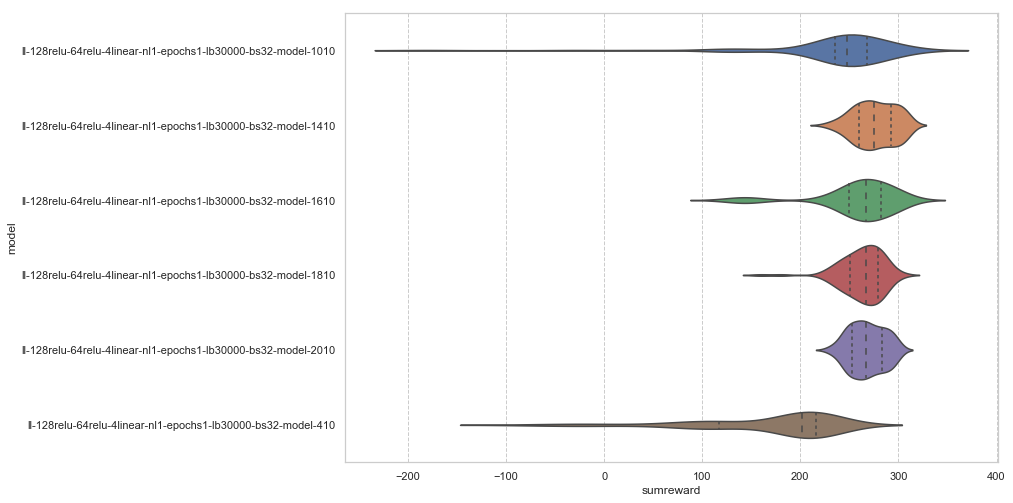

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.violinplot(x='sumreward', y='model', data=sr, inner='quartile')

### Minimal rewards of models

In [44]:
sr.groupby('model').min().sort_values(['sumreward'], ascending=False)

,episode,sumreward,sr_cat
model,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,0,229.980929,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,0,226.773341,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1810,0,159.111153,pos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1610,0,120.745474,pos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-410,0,-87.228161,neg
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1010,0,-180.545205,neg


### Maximal rewards of models

In [45]:
sr.groupby('model').max().sort_values(['sumreward'], ascending=False)

,episode,sumreward,sr_cat
model,,,
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1010,99,317.687348,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1610,99,314.416391,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410,99,311.419706,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1810,99,303.393806,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010,99,300.146494,suppos
ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-410,99,243.872908,suppos


In [9]:
model = load_model('models/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-1410.h5')

In [10]:
env = gym.make('LunarLander-v2')
env.mode = 'human'
s = env.reset()
s = s.reshape(1, 8)
#env.render()
done = False
r_sum = 0
while not done:
    s_pred = model.predict(s)
    a = np.argmax(s_pred)
    new_s, r, done, _ = env.step(a)
    #env.render()
    s = new_s.reshape(1, 8)
    r_sum += r
    
print(f'R: {r_sum}, r: {r}')

R: 315.0535930887596, r: 100


In [10]:
env.close()

In [11]:
model = load_model('models/ll-128relu-64relu-4linear-nl1-epochs1-lb30000-bs32-model-2010.h5')

In [12]:
env = gym.make('LunarLander-v2')
# env.mode = 'human'
s = env.reset()
s = s.reshape(1, 8)
env.render()
done = False
r_sum = 0
while not done:
    s_pred = model.predict(s)
    a = np.argmax(s_pred)
    new_s, r, done, _ = env.step(a)
    env.render()
    s = new_s.reshape(1, 8)
    r_sum += r
print(f'R: {r_sum}, r: {r}')

R: 256.658205470644, r: 100


In [13]:
env.close()

## Conclusion
The agent reached a good level of the performance around 400th episode of the training but sometimes did mistakes. Then, espacialy after the 1010th episode, it looks that the agent was trying to find out optimal balance between maximal performance and a stable result.